<a href="https://colab.research.google.com/github/GermanM3/GermanM3/blob/master/Novy_marx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install finance-datareader

In [ ]:
import pandas as pd
import FinanceDataReader as fdr
import re
import numpy as np
import datetime
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
etfs = fdr.StockListing('ETF/KR')
rep_etfs = etfs[etfs['Name'].str.contains("TIGER", case=False)]


In [ ]:
import concurrent.futures

# ==============================
# 1. 기본 설정
# ==============================
symbols = rep_etfs['Symbol'].tolist()  # 대표 ETF 리스트

start_date = (datetime.datetime.today() - pd.DateOffset(months=120)).strftime('%Y-%m-%d')
end_date = datetime.datetime.today().strftime('%Y-%m-%d')

# ==============================
# 2. 데이터 조회 함수 (월초/월말 포함)
# ==============================
def fetch_monthly_data(sym, start, end):
    try:
        df = fdr.DataReader(sym, start=start, end=end)[['Open', 'Close']]
        df_monthly = pd.DataFrame({
            f'{sym}_Open': df['Open'].resample('MS').first(),  # 월초 시가
            f'{sym}_Close': df['Close'].resample('ME').last()   # 월말 종가
        })
        return df_monthly
    except Exception as e:
        print(f"{sym} 조회 실패: {e}")
        return None

# ==============================
# 3. 병렬 처리
# ==============================
all_data_list = []

max_workers = 8  # CPU 코어 수나 네트워크 상황에 맞게 조절
with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
    futures = {executor.submit(fetch_monthly_data, sym, start_date, end_date): sym for sym in symbols}
    for future in concurrent.futures.as_completed(futures):
        result = future.result()
        if result is not None:
            all_data_list.append(result)

In [ ]:
monthly_merged = pd.concat(all_data_list, axis=1)

# 월초 시가 / 월말 종가 분리
monthly_open = monthly_merged.filter(like='_Open').rename(columns=lambda x: x.replace('_Open',''))
monthly_close = monthly_merged.filter(like='_Close').rename(columns=lambda x: x.replace('_Close',''))

# 인덱스 변환 및 검증
monthly_open.index = pd.to_datetime(monthly_open.index, errors='coerce')
monthly_close.index = pd.to_datetime(monthly_close.index, errors='coerce')
assert monthly_open.index.equals(monthly_close.index), "Index mismatch between open and close"

In [ ]:
monthly_price = monthly_open.combine_first(monthly_close)

In [ ]:
def momentum_backtest(monthly_price, etfs=None, use_filtered=True,
                      N_momentum=12, N_skip=1, top_n=3):
    """
    모멘텀 백테스트 함수. 12-2, 12-7 모멘텀 측정을 위해 N_skip 파라미터 추가.

    :param monthly_price: DataFrame (컬럼=Symbol, 값=가격)
    :param etfs: DataFrame (Symbol, Name 포함)
    :param use_filtered: True면 레버리지/인버스/커버드콜/혼합 종목 제외
    :param N_momentum: 모멘텀 계산을 위한 전체 기간 (예: 12개월)
    :param N_skip: 모멘텀 계산 시 제외할 최근 기간 (예: 12-2 모멘텀은 1개월 제외, N_skip=1)
    :param top_n: 포트폴리오에 편입할 종목 수
    """

    # ✅ 필터링 옵션
    if use_filtered and etfs is not None:
        exclude_pattern = "레버리지|인버스|2X|커버드콜|혼합"
        exclude_symbols = etfs[etfs['Name'].str.contains(exclude_pattern, regex=True)]['Symbol'].tolist()
        monthly_price = monthly_price.drop(columns=[c for c in monthly_price.columns if c in exclude_symbols])

    monthly_price = monthly_price.sort_index()

    # 월말 종가만 추출
    month_end = monthly_price.resample('M').last()

    # =========================================================================
    # ✅ N개월 모멘텀 계산 (N_skip 적용)
    # 현재 시점 (t)와 비교할 N개월 전 시점 (t - N_momentum - N_skip)을 계산

    # 1. 분자 (현재 가격): N_skip 개월 후의 가격을 가져와서 현재 시점으로 shift
    #    예: 12-2 모멘텀 (N_skip=1) -> month_end.shift(-1)이 t-1 가격을 t에 가져옴
    #    하지만 우리는 t-1 가격을 t에 사용하고 싶으므로, shift(N_skip)을 활용하여
    #    'N_skip 개월 전'의 가격을 구하는 대신, 가격을 'N_skip 개월 뒤'로 밀어 계산합니다.

    # 2. 분모 (N개월 전 가격): N_momentum + N_skip 개월 전의 가격

    # 모멘텀 계산을 위한 기준 시작 시점 (t - (N_momentum + N_skip))
    start_price = month_end.shift(N_momentum + N_skip)

    # 모멘텀 계산을 위한 기준 종료 시점 (t - N_skip)
    # 12-2 모멘텀의 경우 t-1월 가격이 모멘텀 종료 가격이 됨. (month_end.shift(N_skip) 사용)
    end_price = month_end.shift(N_skip)

    # 12-2 모멘텀: (P(t-1) / P(t-13)) - 1
    # 12-7 모멘텀: (P(t-7) / P(t-19)) - 1
    momentum = (end_price / start_price) - 1

    # =========================================================================

    results = []
    # 모멘텀 시작 기간 이후부터 백테스트 시작
    # N_momentum + N_skip 만큼의 데이터가 필요하며, 인덱스는 0부터 시작하므로 + N_skip을 더함.
    # 포트폴리오는 i+1월에 구성되므로 len(month_end) - 1 까지 순회
    start_index = N_momentum + N_skip

    for i in range(start_index, len(month_end)-1):
        mom = momentum.iloc[i]
        # NaN 값 제거 후 top_n 선정
        top_symbols = mom.dropna().nlargest(top_n).index
        top_scores = mom[top_symbols]

        # 익월 월초~말일 수익률 계산
        next_month_idx = month_end.index[i+1]

        # 익월의 첫 거래일 가격 (매수 시점)
        next_month_start = monthly_price.loc[monthly_price.index >= next_month_idx.replace(day=1)].iloc[0]
        # 익월의 마지막 거래일 가격 (매도 시점)
        next_month_end = month_end.iloc[i+1]

        returns = (next_month_end[top_symbols] - next_month_start[top_symbols]) / next_month_start[top_symbols]
        portfolio_return = returns.mean()

        results.append({
            'Month': next_month_idx.strftime('%Y-%m'),
            'Selected': list(top_symbols),
            'Momentum': list(top_scores.round(4)),
            'NextMonthReturn': list(returns.round(4)),
            'PortfolioReturn': round(portfolio_return, 4)
        })

    monthly_results = pd.DataFrame(results)
    cumulative_returns = (1 + monthly_results['PortfolioReturn']).cumprod()

    return monthly_results, cumulative_returns

In [ ]:
# 예시: 12-2 모멘텀 테스트
# monthly_price와 etfs DataFrame이 미리 정의되어 있다고 가정합니다.
results_N_n, cumulative_N_n = momentum_backtest(monthly_price, etfs=etfs, N_momentum=6, N_skip=2, top_n=3)

In [312]:
#cumulative_N_n.pct_change().dropna().to_excel("momentum_cumulative_return.xlsx")

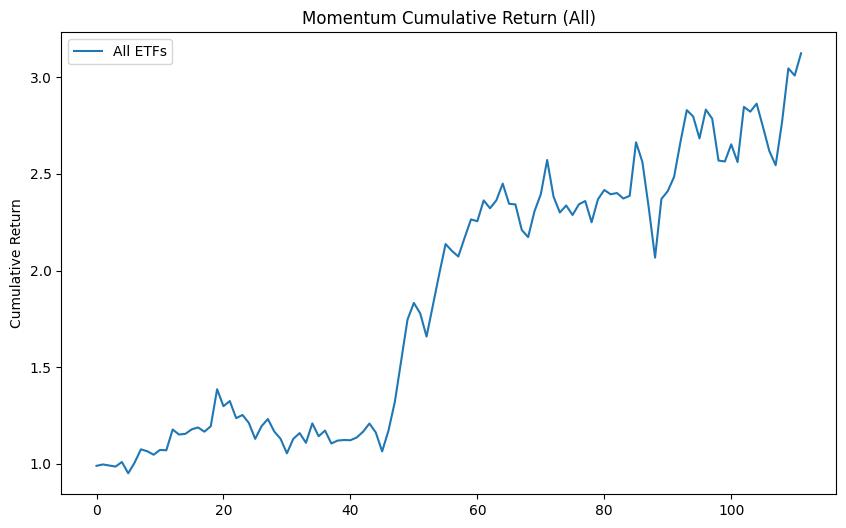

In [ ]:
# 📊 누적 수익률 비교 시각화
plt.figure(figsize=(10,6))
cumulative_N_n.plot(label="All ETFs")
#cum_ret_filtered.plot(label="Filtered ETFs")
plt.title("Momentum Cumulative Return (All)")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()

In [ ]:
import pandas as pd
import numpy as np

def performance_stats(cumulative_returns):
    """성과지표 계산 (CAGR, MDD, Sharpe, Calmar)"""
    # 연환산 수익률 (CAGR)
    total_return = cumulative_returns.iloc[-1] - 1
    years = len(cumulative_returns) / 12
    cagr = (1 + total_return) ** (1 / years) - 1

    # 최대낙폭 (MDD)
    running_max = cumulative_returns.cummax()
    drawdown = cumulative_returns / running_max - 1
    mdd = drawdown.min()  # 음수 값

    # 샤프비율 (단순, 무위험수익률=0)
    monthly_returns = cumulative_returns.pct_change().dropna()
    sharpe = (monthly_returns.mean() / monthly_returns.std()) * np.sqrt(12)

    # Calmar Ratio = CAGR / |MDD|
    calmar = cagr / abs(mdd) if mdd != 0 else np.nan

    return round(cagr,4), round(mdd,4), round(sharpe,4), round(calmar,4)


def optimize_momentum(monthly_price, etfs,
                      momentum_list=[6,9,12],
                      skip_list=[1,2],
                      topn_list=[3,5]):
    results = []
    for N_mom in momentum_list:
        for N_skip in skip_list:
            for top_n in topn_list:
                monthly_results, cumulative = momentum_backtest(
                    monthly_price, etfs=etfs,
                    N_momentum=N_mom, N_skip=N_skip, top_n=top_n
                )
                cagr, mdd, sharpe, calmar = performance_stats(cumulative)
                results.append([N_mom, N_skip, top_n, cagr, mdd, sharpe, calmar])
    return pd.DataFrame(results,
                        columns=["N_momentum","N_skip","top_n","CAGR","MDD","Sharpe","Calmar"])


In [ ]:
df_opt = optimize_momentum(monthly_price, etfs,
                           momentum_list=[3,6,9,12],
                           skip_list=[1,2,3],
                           topn_list=[3,5,7])

print(df_opt.sort_values("Calmar", ascending=False).head(10))

    N_momentum  N_skip  top_n    CAGR     MDD  Sharpe  Calmar
12           6       2      3  0.1298 -0.2394  0.7297  0.5422
4            3       2      5  0.1103 -0.3238  0.6551  0.3408
13           6       2      5  0.0906 -0.2971  0.5594  0.3050
5            3       2      7  0.0928 -0.3480  0.5926  0.2665
3            3       2      3  0.1102 -0.4610  0.5963  0.2390
19           9       1      5  0.0688 -0.3106  0.4576  0.2216
15           6       3      3  0.0721 -0.3503  0.4682  0.2059
20           9       1      7  0.0656 -0.3372  0.4620  0.1946
25           9       3      5  0.0673 -0.3552  0.4728  0.1894
23           9       2      7  0.0652 -0.3450  0.4501  0.1889


In [ ]:
import pandas as pd
import numpy as np

def get_next_month_portfolio_df(monthly_price, etfs=None,
                                N_momentum=12, N_skip=1, top_n=3,
                                reference_date=None, use_filtered=False):
    """
    특정 기준 월말 기준으로 다음달 포트폴리오 종목을 DataFrame으로 반환
    NextMonthReturn 제외, 종목 선정 + 모멘텀만 출력
    """

    if use_filtered and etfs is not None:
        exclude_pattern = "레버리지|인버스|2X|커버드콜|혼합"
        exclude_symbols = etfs[etfs['Name'].str.contains(exclude_pattern, regex=True)]['Symbol'].tolist()
        monthly_price = monthly_price.drop(columns=[c for c in monthly_price.columns if c in exclude_symbols])

    monthly_price = monthly_price.sort_index()
    month_end = monthly_price.resample('M').last()

    ref = pd.to_datetime(reference_date) + pd.offsets.MonthEnd(0)
    if ref not in month_end.index:
        raise ValueError(f"{reference_date} 는 월말 데이터에 없음.")

    i = month_end.index.get_loc(ref)
    if i < (N_momentum + N_skip):
        raise ValueError("데이터가 부족합니다. 더 긴 기간 필요.")

    # 모멘텀 계산
    start_price = month_end.shift(N_momentum + N_skip)
    end_price = month_end.shift(N_skip)
    momentum = (end_price / start_price) - 1
    mom = momentum.iloc[i]

    # top_n 선정
    top_symbols = mom.dropna().nlargest(top_n).index
    top_scores = mom[top_symbols]

    # 이름 매핑
    if etfs is not None:
        names = etfs.set_index("Symbol").loc[top_symbols, "Name"].tolist()
    else:
        names = list(top_symbols)

    # DataFrame 생성
    df = pd.DataFrame({
        "ReferenceMonth": [ref.strftime("%Y-%m")],
        "NextMonth": [(ref + pd.offsets.MonthEnd(1)).strftime("%Y-%m")],
        "Selected": [list(top_symbols)],
        "Names": [names],
        "Momentum": [list(top_scores.round(4))]
    })

    return df

In [ ]:
df_portfolio = get_next_month_portfolio_df(monthly_price, etfs,
                                           N_momentum=6, N_skip=2, top_n=3,
                                           reference_date="2025-08")

In [315]:
def combined_portfolio_backtest(monthly_price, etfs,
                                N_momentum=6, N_skip=2, top_n=3,
                                momentum_weight=0.7, bond_weight=0.3,
                                us_index_weight=0):
    """
    모멘텀 전략과 채권/미국 지수 ETF를 조합한 포트폴리오 백테스트 함수.

    :param monthly_price: DataFrame (컬럼=Symbol, 값=가격)
    :param etfs: DataFrame (Symbol, Name 포함)
    :param N_momentum: 모멘텀 계산을 위한 전체 기간
    :param N_skip: 모멘텀 계산 시 제외할 최근 기간
    :param top_n: 모멘텀 전략에서 편입할 종목 수
    :param momentum_weight: 모멘텀 전략 비중
    :param bond_weight: 채권 ETF 비중
    :param us_index_weight: 미국 지수 ETF 비중 (S&P500, 나스닥100)
    """

    # 필터링 옵션 (모멘텀 전략에만 적용)
    exclude_pattern = "레버리지|인버스|2X|커버드콜|혼합"
    filtered_symbols = monthly_price.columns[~monthly_price.columns.isin(
        etfs[etfs['Name'].str.contains(exclude_pattern, regex=True)]['Symbol'].tolist()
    )].tolist()
    monthly_price_filtered = monthly_price[filtered_symbols].copy()


    monthly_price_filtered = monthly_price_filtered.sort_index()

    # 월말 종가만 추출
    month_end_filtered = monthly_price_filtered.resample('M').last()

    # 모멘텀 계산 (필터링된 데이터 사용)
    start_price_filtered = month_end_filtered.shift(N_momentum + N_skip)
    end_price_filtered = month_end_filtered.shift(N_skip)
    momentum_filtered = (end_price_filtered / start_price_filtered) - 1

    results = []
    start_index = N_momentum + N_skip

    # 채권 및 미국 지수 ETF 찾기
    bond_etfs = etfs[etfs['Name'].str.contains("국고채|종합채|회사채", case=False) &
                     ~etfs['Name'].str.contains(exclude_pattern, regex=True)]['Symbol'].tolist()
    us_sp500_etfs = etfs[etfs['Name'].str.contains("S&P500", case=False) &
                         ~etfs['Name'].str.contains(exclude_pattern, regex=True)]['Symbol'].tolist()
    us_nasdaq100_etfs = etfs[etfs['Name'].str.contains("나스닥100", case=False) &
                             ~etfs['Name'].str.contains(exclude_pattern, regex=True)]['Symbol'].tolist()
    us_long_bond_etfs = etfs[etfs['Name'].str.contains("미국채.+10년", case=False) &
                             ~etfs['Name'].str.contains(exclude_pattern, regex=True)]['Symbol'].tolist()


    # 조합할 ETF 선택 (예시: 채권은 첫 번째 채권 ETF, 미국 지수는 첫 번째 S&P500과 나스닥100)
    # 실제 사용 시에는 비중 분배 로직이 더 필요할 수 있습니다.
    combined_etf_symbols = []
    if bond_weight > 0 and bond_etfs:
        combined_etf_symbols.append(bond_etfs[0]) # 첫 번째 채권 ETF
    if us_index_weight > 0 and us_sp500_etfs:
         combined_etf_symbols.append(us_sp500_etfs[0]) # 첫 번째 S&P500 ETF
    if us_index_weight > 0 and us_nasdaq100_etfs and len(combined_etf_symbols) < 2: # 미국 지수 ETF가 2개 필요할 경우
        combined_etf_symbols.append(us_nasdaq100_etfs[0]) # 첫 번째 나스닥100 ETF
    if us_index_weight > 0 and us_long_bond_etfs and len(combined_etf_symbols) < 3: # 미국 10년물 ETF가 필요할 경우
        combined_etf_symbols.append(us_long_bond_etfs[0]) # 첫 번째 미국 10년물 ETF


    # 조합할 ETF의 월초/월말 가격 데이터
    # Check if combined_etf_symbols are in monthly_price columns
    valid_combined_etf_symbols = [sym for sym in combined_etf_symbols if sym in monthly_price.columns]
    monthly_price_combined_etfs = monthly_price[valid_combined_etf_symbols].copy()
    month_end_combined_etfs = monthly_price_combined_etfs.resample('M').last()


    for i in range(start_index, len(month_end_filtered)-1):
        # 모멘텀 전략 종목 선정
        mom = momentum_filtered.iloc[i]
        top_symbols = mom.dropna().nlargest(top_n).index.tolist()

        # 익월 월초~말일 수익률 계산
        next_month_idx = month_end_filtered.index[i+1]

        # 익월의 첫 거래일 가격 (매수 시점)
        next_month_start = monthly_price.loc[monthly_price.index >= next_month_idx.replace(day=1)].iloc[0]
        # 익월의 마지막 거래일 가격 (매도 시점)
        next_month_end = monthly_price.resample('M').last().iloc[i+1]

        # Ensure selected symbols are in next_month_start and next_month_end
        valid_top_symbols = [sym for sym in top_symbols if sym in next_month_start.index and sym in next_month_end.index]
        valid_combined_etf_symbols_month = [sym for sym in combined_etf_symbols if sym in next_month_start.index and sym in next_month_end.index]


        # 모멘텀 전략 부분 수익률 계산
        momentum_returns = (next_month_end[valid_top_symbols] - next_month_start[valid_top_symbols]) / next_month_start[valid_top_symbols]
        avg_momentum_return = momentum_returns.mean() if not momentum_returns.empty else 0

        # 조합할 ETF 부분 수익률 계산
        combined_etf_returns = (next_month_end[valid_combined_etf_symbols_month] - next_month_start[valid_combined_etf_symbols_month]) / next_month_start[valid_combined_etf_symbols_month]

        # 포트폴리오 전체 수익률 계산 (비중 적용)
        portfolio_return = (avg_momentum_return * momentum_weight) + \
                           (combined_etf_returns[bond_etfs[0]].mean() * bond_weight if bond_weight > 0 and bond_etfs and bond_etfs[0] in combined_etf_returns.index else 0) + \
                           (combined_etf_returns[us_sp500_etfs[0]].mean() * us_index_weight/2 if us_index_weight > 0 and us_sp500_etfs and us_sp500_etfs[0] in combined_etf_returns.index else 0) + \
                           (combined_etf_returns[us_nasdaq100_etfs[0]].mean() * us_index_weight/2 if us_index_weight > 0 and us_nasdaq100_etfs and us_nasdaq100_etfs[0] in combined_etf_returns.index else 0) + \
                           (combined_etf_returns[us_long_bond_etfs[0]].mean() * us_index_weight/2 if us_index_weight > 0 and us_long_bond_etfs and us_long_bond_etfs[0] in combined_etf_returns.index else 0) # 미국 10년물 ETF 비중 추가


        results.append({
            'Month': next_month_idx.strftime('%Y-%m'),
            'PortfolioReturn': round(portfolio_return, 4)
        })

    monthly_results = pd.DataFrame(results)
    cumulative_returns = (1 + monthly_results['PortfolioReturn']).cumprod()

    return monthly_results, cumulative_returns

In [316]:
# 예시 1: 모멘텀 70%, 채권 30% 백테스트
results_70_30_bond, cumulative_70_30_bond = combined_portfolio_backtest(
    monthly_price, etfs, N_momentum=6, N_skip=2, top_n=3,
    momentum_weight=0.7, bond_weight=0.3, us_index_weight=0
)

print("모멘텀 70%, 채권 30% 포트폴리오 누적 수익률:")
display(cumulative_70_30_bond.tail())

# 예시 2: 모멘텀 70%, S&P500 15%, 나스닥100 15% 백테스트
results_70_30_us_index, cumulative_70_30_us_index = combined_portfolio_backtest(
    monthly_price, etfs, N_momentum=6, N_skip=2, top_n=3,
    momentum_weight=0.7, bond_weight=0, us_index_weight=0.3 # us_index_weight 0.3으로 설정 (S&P500 0.15, 나스닥100 0.15)
)

print("\n모멘텀 70%, S&P500 15%, 나스닥100 15% 포트폴리오 누적 수익률:")
display(cumulative_70_30_us_index.tail())

# 예시 3: 모멘텀 70%, 채권 15%, S&P500 15% 백테스트
results_70_15_15_bond_us_bond, cumulative_70_15_15_bond_us_bond = combined_portfolio_backtest(
    monthly_price, etfs, N_momentum=6, N_skip=2, top_n=3,
    momentum_weight=0.7, bond_weight=0.15, us_index_weight=0.15 # 채권 0.15, 미국 10년물 0.15
)

print("\n모멘텀 70%, 채권 15%, 미국 10년물 15% 포트폴리오 누적 수익률:")
display(cumulative_70_15_15_bond_us_bond.tail())

모멘텀 70%, 채권 30% 포트폴리오 누적 수익률:


,PortfolioReturn
107,1.990418
108,2.112032
109,2.261142
110,2.241922
111,2.302006



모멘텀 70%, S&P500 15%, 나스닥100 15% 포트폴리오 누적 수익률:


,PortfolioReturn
107,1.632216
108,1.749246
109,1.908428
110,1.904038
111,1.980771



모멘텀 70%, 채권 15%, 미국 10년물 15% 포트폴리오 누적 수익률:


,PortfolioReturn
107,1.392457
108,1.480599
109,1.592384
110,1.581556
111,1.628212


In [317]:
# 오리지널 모멘텀 전략 (예시로 사용했던 6-2 모멘텀)의 성과 지표 계산
cagr_N_n, mdd_N_n, sharpe_N_n, calmar_N_n = performance_stats(cumulative_N_n)
print(f"Original Momentum (6-2, Top 3) - CAGR: {cagr_N_n}, MDD: {mdd_N_n}, Sharpe: {sharpe_N_n}, Calmar: {calmar_N_n}")

# 모멘텀 70%, 채권 30% 포트폴리오 성과 지표 계산
cagr_70_30_bond, mdd_70_30_bond, sharpe_70_30_bond, calmar_70_30_bond = performance_stats(cumulative_70_30_bond)
print(f"Momentum 70%, Bond 30% - CAGR: {cagr_70_30_bond}, MDD: {mdd_70_30_bond}, Sharpe: {sharpe_70_30_bond}, Calmar: {calmar_70_30_bond}")

# 모멘텀 70%, S&P500 15%, 나스닥100 15% 포트폴리오 성과 지표 계산
cagr_70_30_us_index, mdd_70_30_us_index, sharpe_70_30_us_index, calmar_70_30_us_index = performance_stats(cumulative_70_30_us_index)
print(f"Momentum 70%, S&P500 15%, Nasdaq 100 15% - CAGR: {cagr_70_30_us_index}, MDD: {mdd_70_30_us_index}, Sharpe: {sharpe_70_30_us_index}, Calmar: {calmar_70_30_us_index}")

# 모멘텀 70%, 채권 15%, 미국 10년물 15% 포트폴리오 성과 지표 계산
cagr_70_15_15_bond_us_bond, mdd_70_15_15_bond_us_bond, sharpe_70_15_15_bond_us_bond, calmar_70_15_15_bond_us_bond = performance_stats(cumulative_70_15_15_bond_us_bond)
print(f"Momentum 70%, Bond 15%, US Long Bond 15% - CAGR: {cagr_70_15_15_bond_us_bond}, MDD: {mdd_70_15_15_bond_us_bond}, Sharpe: {sharpe_70_15_15_bond_us_bond}, Calmar: {calmar_70_15_15_bond_us_bond}")

Original Momentum (6-2, Top 3) - CAGR: 0.1298, MDD: -0.2394, Sharpe: 0.7297, Calmar: 0.5422
Momentum 70%, Bond 30% - CAGR: 0.0934, MDD: -0.1718, Sharpe: 0.7294, Calmar: 0.5438
Momentum 70%, S&P500 15%, Nasdaq 100 15% - CAGR: 0.076, MDD: -0.1722, Sharpe: 0.8473, Calmar: 0.4411
Momentum 70%, Bond 15%, US Long Bond 15% - CAGR: 0.0536, MDD: -0.1631, Sharpe: 0.7104, Calmar: 0.3287


In [ ]:
#df_portfolio['Names'].to_list()

[['TIGER K방산&우주', 'TIGER 200 중공업', 'TIGER 200 건설']]

In [ ]:
cumulative_N_n

,ReferenceMonth,NextMonth,Selected,Names,Momentum
0,2025-08,2025-09,"[463250, 139230, 139220]","[TIGER K방산&우주, TIGER 200 중공업, TIGER 200 건설]","[1.5497, 1.0188, 0.7699]"
